### Semantic Analysis

In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

from google import genai
from google.genai.types import EmbedContentConfig
from google.genai import types

from scipy.spatial import ConvexHull

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import re
from tqdm import tqdm

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from sklearn.cluster import DBSCAN

import glob

import nltk
from nltk.tokenize import sent_tokenize

import plotly.express as px

import seaborn as sns

import hdbscan

from sklearn.preprocessing import normalize
from gap_statistic import OptimalK  



In [3]:
#Load all CSV files and concatenate them into a single DataFrame
folder_path = '../output/free_response_output/'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))


df_list = [pd.read_csv(file) for file in csv_files]
llm_df = pd.concat(df_list, ignore_index=True)

#Save df into a csv file in case it's needed
llm_df.to_csv('../output/free_response_output/final_df/llm_df.csv', index=False)

In [18]:
csv_files

['../output/free_response_output/free_emo_Cubism3.csv',
 '../output/free_response_output/free_emo_Cubism.csv',
 '../output/free_response_output/free_emo_Cubism2.csv',
 '../output/free_response_output/free_emo_colorField4.csv',
 '../output/free_response_output/free_emo_colorField5.csv',
 '../output/free_response_output/free_emo_Cubism5.csv',
 '../output/free_response_output/free_emo_Cubism4.csv',
 '../output/free_response_output/free_emo_colorField2.csv',
 '../output/free_response_output/free_emo_colorField3.csv',
 '../output/free_response_output/free_emo_colorField.csv',
 '../output/free_response_output/free_emo_impressionism.csv',
 '../output/free_response_output/free_emo_abstract.csv',
 '../output/free_response_output/free_emo_leslie.csv',
 '../output/free_response_output/free_emo_leslie3.csv',
 '../output/free_response_output/free_emo_leslie2.csv',
 '../output/free_response_output/free_emo_abstract3.csv',
 '../output/free_response_output/free_emo_abstract2.csv',
 '../output/free_res

In [19]:
#combine image and image_category into a single column
llm_df['image'] = (
    llm_df['image'].astype(str)
    + '_'
    + llm_df['image_category'].astype(str)
)

In [20]:
llm_df

image image_category  \
0                           at-wattle-1972-5.jpg_Cubism         Cubism   
1                    baj-chez-picasso-4-1969.jpg_Cubism         Cubism   
2           ang-magbabayo-pounding-rice-1979.jpg_Cubism         Cubism   
3     animal-destinies-the-trees-show-their-rings-th...         Cubism   
4                      arlequin-dansant-1924.jpg_Cubism         Cubism   
...                                                 ...            ...   
4335  woodland-stream-in-a-winter-landscape.jpg_impr...  impressionism   
4336  yerres-part-of-the-south-facade-of-the-casin.j...  impressionism   
4337  young-woman-in-a-garden-cagnes-1905.jpg_impres...  impressionism   
4338         young-girl-in-the-fields.jpg_impressionism  impressionism   
4339                zimsko-jutro-1911.jpg_impressionism  impressionism   

                                          free_response  
0     Viewing this painting brings a profound sense ...  
1     This painting makes me feel a strong sense of ...  
2     This painting truly brings a sense of warmth a...  
3     This painting makes me feel deeply disturbed a...  
4     Looking at this painting, I feel a strong sens...  
...                                                 ...  
4335  Looking at this painting just makes me feel a ...  
4336  Looking at this painting fills me with a wonde...  
4337  Looking at this painting, I feel an immediate ...  
4338  This painting truly evokes a deep sense of pea...  
4339  Looking at this painting, I feel a profound se...  

[4340 rows x 3 columns]

In [21]:
#Split the free_response column into sentences, each sentence will be a separate row

nltk.download('punkt')

rows = []
for _,row in llm_df.iterrows():
    pid = row['image']
    text = row['free_response']
    for sent in sent_tokenize(text):
        rows.append({
            'image': pid,
            'image_category': row['image_category'],
            'free_response': sent            
        })

sentence_df = pd.DataFrame(rows)


[nltk_data] Downloading package punkt to /Users/Stella/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
sentence_df

image image_category  \
0              at-wattle-1972-5.jpg_Cubism         Cubism   
1              at-wattle-1972-5.jpg_Cubism         Cubism   
2              at-wattle-1972-5.jpg_Cubism         Cubism   
3              at-wattle-1972-5.jpg_Cubism         Cubism   
4       baj-chez-picasso-4-1969.jpg_Cubism         Cubism   
...                                    ...            ...   
19082  zimsko-jutro-1911.jpg_impressionism  impressionism   
19083  zimsko-jutro-1911.jpg_impressionism  impressionism   
19084  zimsko-jutro-1911.jpg_impressionism  impressionism   
19085  zimsko-jutro-1911.jpg_impressionism  impressionism   
19086  zimsko-jutro-1911.jpg_impressionism  impressionism   

                                           free_response  
0      Viewing this painting brings a profound sense ...  
1      There's a heartwarming feeling that emerges fr...  
2      It evokes a comforting nostalgia, like a glimp...  
3      The scene feels incredibly serene and tranquil...  
4      This painting makes me feel a strong sense of ...  
...                                                  ...  
19082  Looking at this painting, I feel a profound se...  
19083  There's something really calming about the sof...  
19084  It evokes a feeling of peaceful solitude, a bi...  
19085  I feel a gentle stillness, like everything has...  
19086  It's very introspective and creates a sense of...  

[19087 rows x 3 columns]

In [ ]:
# Generate Sentence Embeddings for LLM explanations
# The produced embedding is already L2 normalized, good for cosine similarity calculations

# 1. Init Vertex-backed GenAI client
client = genai.Client(
    vertexai=True,
    project="emotion-art-analysis",
    location="us-central1",
)
texts = llm_df['free_response'].fillna("").astype(str)

# 3. Embed one at a time (batchSize must be 1)
sentence_embs = []
for sentence in tqdm(sentence_df['free_response'], desc="Embedding sentences"):    
    resp = client.models.embed_content(
        model="gemini-embedding-001",
        contents=[sentence],  
        config=EmbedContentConfig(
            task_type="CLUSTERING",

        ),
    )
    # grab the single embedding vector
    sentence_embs.append(resp.embeddings[0].values)

# 4. Attach embeddings and save
sentence_df['embedding'] = sentence_embs


sentence_df.to_parquet('../output/embeddings/free_embedded_sentences.parquet', index=False)

print("✓ All explanations embedded and saved to free_embedded_sentences.parquet")

Embedding sentences: 100%|██████████| 19087/19087 [36:49<00:00,  8.64it/s] 


✓ All explanations embedded and saved to free_embedded_sentences.parquet


In [4]:
#import dataset
embeddings_df = pd.read_parquet('../output/embeddings/free_embedded_sentences.parquet')
embeddings = np.array(embeddings_df['embedding'].tolist())



In [29]:
len(embeddings_df['embedding'][0])

3072

In [37]:
umap2d = umap.UMAP(
    random_state=42,
    metric='cosine',
    n_neighbors=50,
    n_components=2,
    min_dist=0.0
).fit_transform(embeddings)


df2 = pd.DataFrame(umap2d, columns=['UMAP1','UMAP2'])

# Interactive 2D scatter
fig = px.scatter(
    df2,
    x='UMAP1',
    y='UMAP2',
    title='2D UMAP Projection',
    color_discrete_sequence=px.colors.qualitative.Set1,
    opacity=0.8,
    width=800,
    height=600
)
fig.update_layout(legend_title='Cluster')
fig.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Number of components for 75% variance: 250
Cumulative variance by component:
[0.10335309 0.18889622 0.25717675 0.2949398  0.33008653 0.35918637
 0.3846126  0.40718539 0.42735107 0.44536595 0.46076857 0.4749089
 0.48833683 0.50077997 0.51205534 0.52277432 0.53196758 0.54082286
 0.54900674 0.55672812 0.56402024 0.57124872 0.57795992 0.58445492
 0.59047852 0.59642322 0.6021375  0.60767903 0.61315032 0.61845389
 0.62347515 0.62820175 0.63272612 0.63723094 0.64155342 0.64581643
 0.65002841 0.65395463 0.65782698 0.66161752 0.66525852 0.66873445
 0.67213643 0.67548278 0.67874819 0.68198447 0.68509822 0.68808367
 0.69103447 0.69397074 0.6968114  0.69961673 0.70239055 0.70508516
 0.70770133 0.71026706 0.71282164 0.71531736 0.71778407 0.7201697
 0.72254464 0.72487144 0.72717819 0.72942642 0.73163959 0.73383855
 0.7359963  0.73809006 0.74017175 0.74219327 0.74420233 0.74616551
 0.74811949 0.75001409 0.75187924 0.75372659 0.75551837 0.75730416
 0.7590647  0.76080968 0.76252812 0.76423835 0.7659236

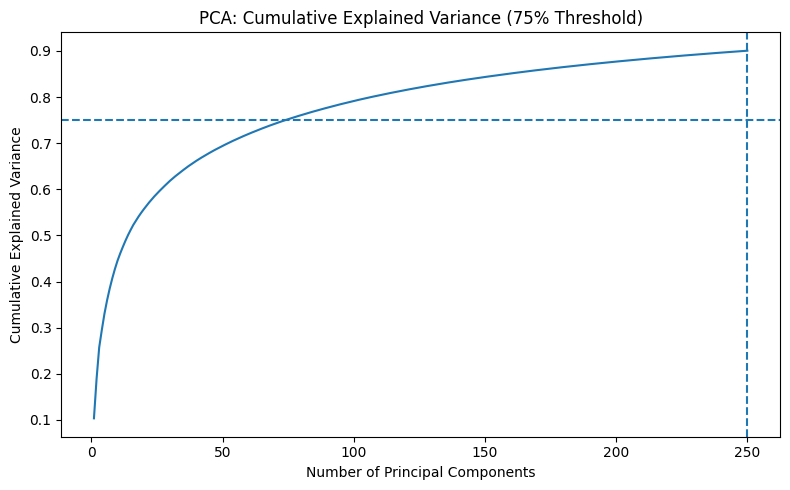

In [ ]:
#Check with PCA how many components are needed to retain 75% of variance
pca75 = PCA(n_components=0.9, random_state=0)  
X_reduced = pca75.fit_transform(embeddings)

n_comps = pca75.n_components_
print(f"Number of components for 75% variance: {n_comps}")

# Check the actual cumulative variance explained
cum_var = np.cumsum(pca75.explained_variance_ratio_)
print(f"Cumulative variance by component:\n{cum_var}")

# Optionally, inspect the exact ratio retained
print(f"Total variance retained: {cum_var[-1]:.2%}")


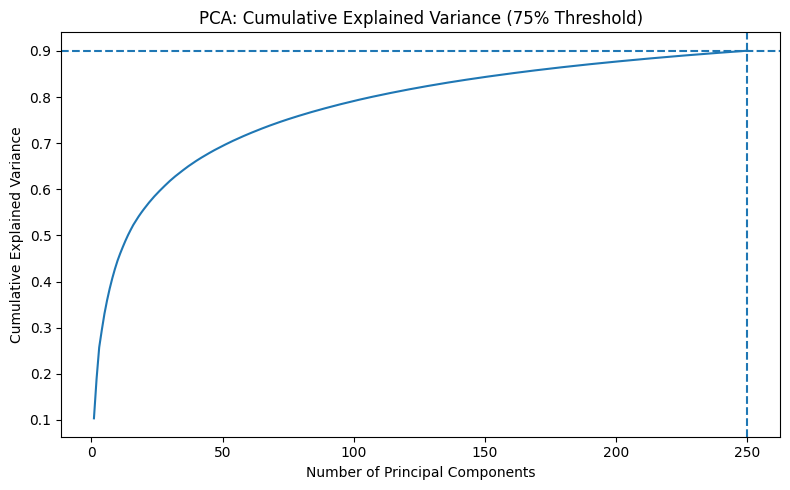

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_var)+1), cum_var)
plt.axhline(0.9, linestyle='--')
plt.axvline(n_comps,    linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance (90% Threshold)')
plt.tight_layout()
plt.show()

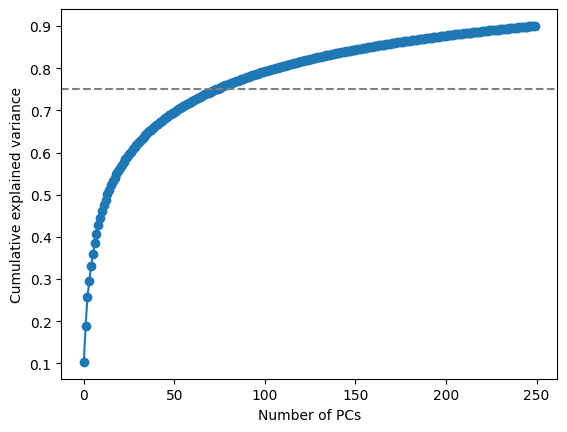

In [19]:
#Use elbow method to determine optimal number of clusters
ratios = pca75.explained_variance_ratio_
cum = ratios.cumsum()
plt.plot(cum, marker='o')
plt.axhline(0.75, color='grey', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative explained variance')
plt.show()


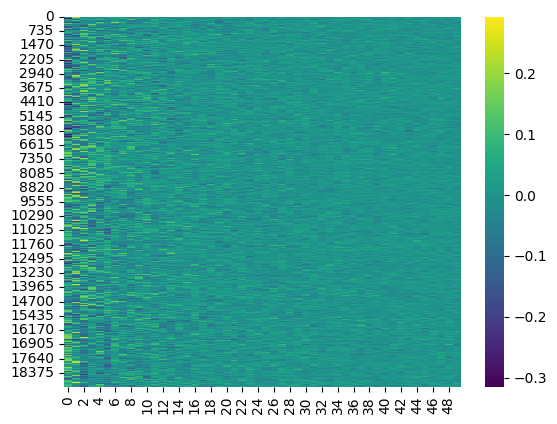

In [21]:
# Check PCA with 50 components
pca50 = PCA(n_components=50) 
reduced_embedding = pca50.fit_transform(embeddings)

# Now plot a heatmap of the reduced embeddings
sns.heatmap(reduced_embedding, cmap='viridis')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



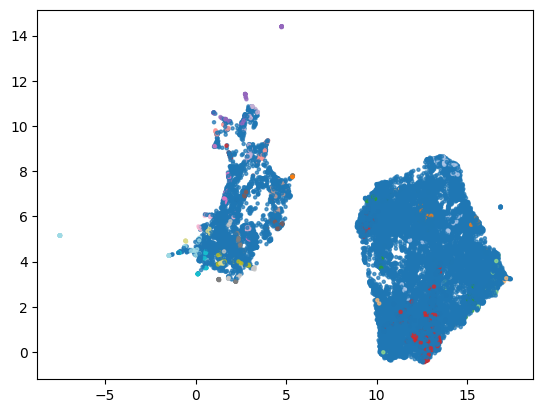

In [ ]:
#check with 50 components PCA then cluster with HDBSCAN

clusterer = hdbscan.HDBSCAN( metric="euclidean")
labels = clusterer.fit_predict(reduced_embedding)

# 3. Visualize in 2D UMAP
X2 = umap.UMAP(n_components=2, random_state=0).fit_transform(reduced_embedding)
plt.scatter(X2[:,0], X2[:,1], c=labels, s=5, cmap='tab20', alpha=0.7)
plt.show()

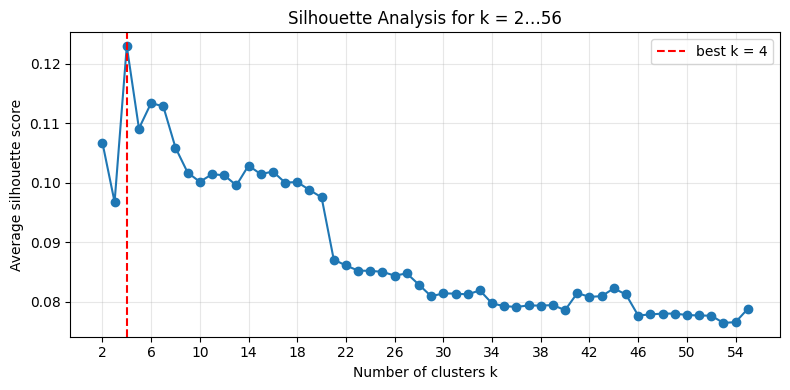


▶ Best k by silhouette: 4 (score = 0.123)


In [51]:
#kmeans with 50 components

#determine best_k
ks = list(range(2, 56))
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(reduced_embedding)
    labels = km.labels_
    score = silhouette_score(reduced_embedding, labels, metric='euclidean')
    sil_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(ks, sil_scores, marker='o', linestyle='-')
plt.xticks(ks[::4])             
plt.xlabel('Number of clusters k')
plt.ylabel('Average silhouette score')
plt.title('Silhouette Analysis for k = 2…56')
plt.grid(alpha=0.3)

#highlight the best k
best_k = ks[sil_scores.index(max(sil_scores))]
best_score = max(sil_scores)
plt.axvline(best_k, color='red', linestyle='--', label=f'best k = {best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n▶ Best k by silhouette: {best_k} (score = {best_score:.3f})")

#kmean clustering with best_k
X_norm = normalize(reduced_embedding, axis=1)    # rows → unit length
km = KMeans(n_clusters=best_k, random_state=0).fit(X_norm)
kmean_labels = km.labels_

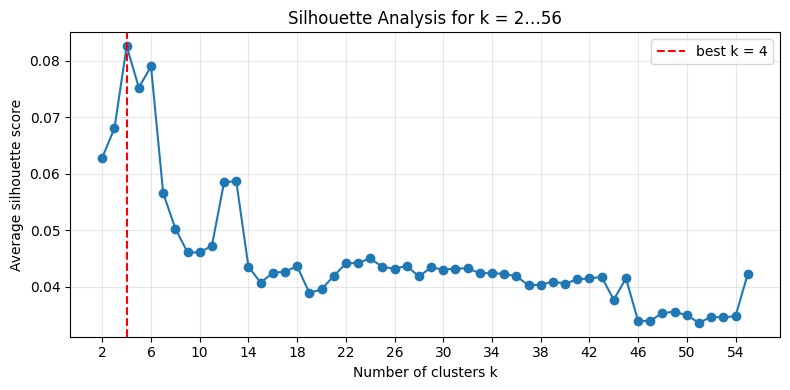


▶ Best k by silhouette: 4 (score = 0.083)


In [58]:
#kmeans with raw embedding data

#determine best_k
ks = list(range(2, 56))
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    labels = km.labels_
    score = silhouette_score(embeddings, labels, metric='euclidean')
    sil_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(ks, sil_scores, marker='o', linestyle='-')
plt.xticks(ks[::4])             
plt.xlabel('Number of clusters k')
plt.ylabel('Average silhouette score')
plt.title('Silhouette Analysis for k = 2…56')
plt.grid(alpha=0.3)

#highlight the best k
best_k = ks[sil_scores.index(max(sil_scores))]
best_score = max(sil_scores)
plt.axvline(best_k, color='red', linestyle='--', label=f'best k = {best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n▶ Best k by silhouette: {best_k} (score = {best_score:.3f})")

#kmean clustering with best_k
X_norm = normalize(reduced_embedding, axis=1)    # rows → unit length
km = KMeans(n_clusters=best_k, random_state=0).fit(X_norm)
org_kmean_labels = km.labels_

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



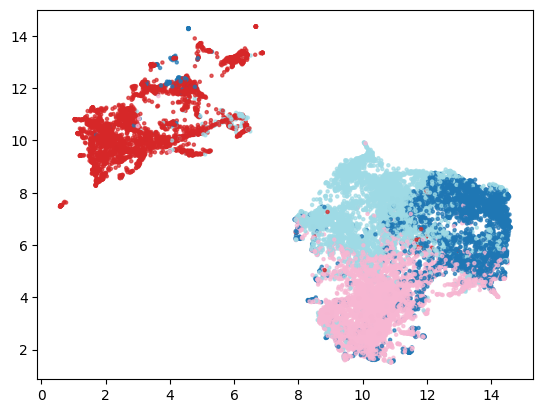

In [60]:
X2 = umap.UMAP(n_components=2, min_dist = 0, n_neighbors = 20,random_state=0).fit_transform(embeddings)
plt.scatter(X2[:,0], X2[:,1], c=org_kmean_labels, s=5, cmap='tab20', alpha=0.7)
plt.show()

Running UMAP with n_neighbors=10


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



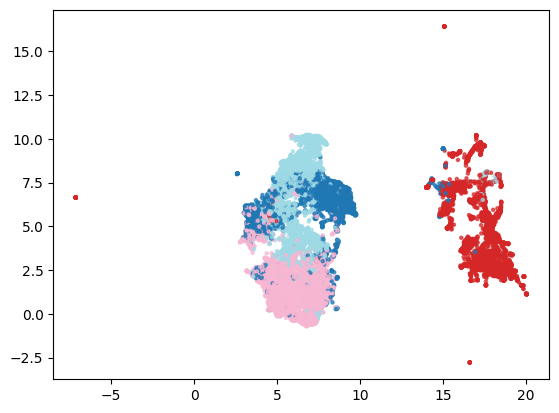

Running UMAP with n_neighbors=15


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



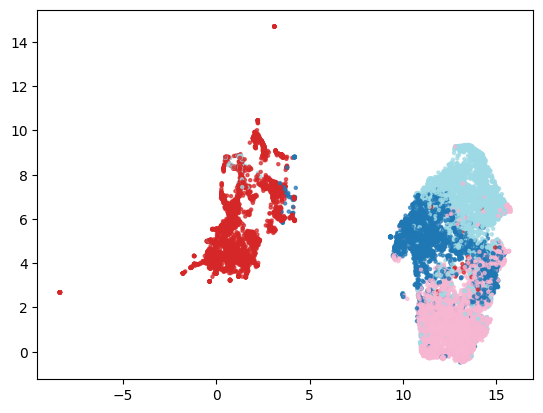

Running UMAP with n_neighbors=20


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



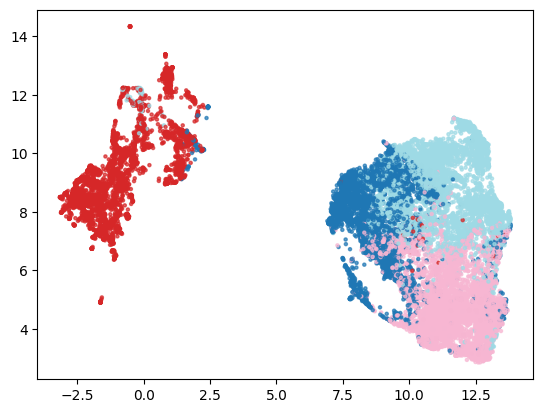

Running UMAP with n_neighbors=25


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



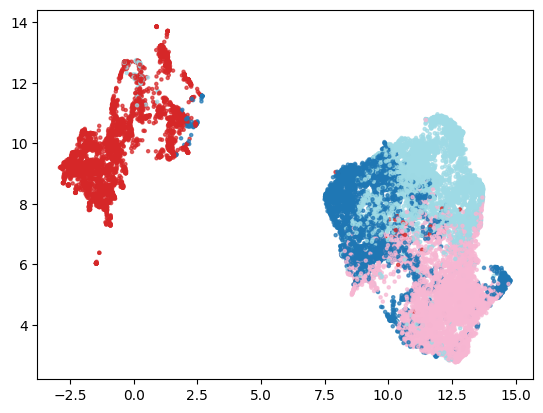

Running UMAP with n_neighbors=30


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



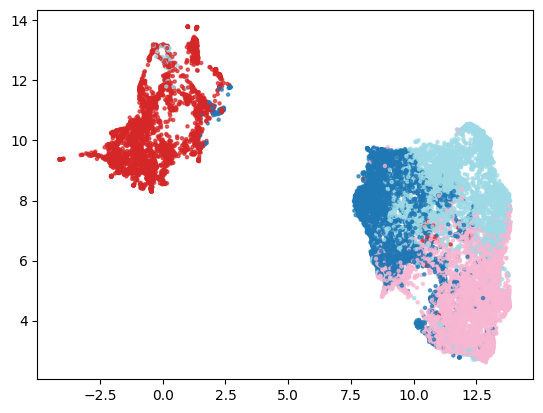

Running UMAP with n_neighbors=35


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



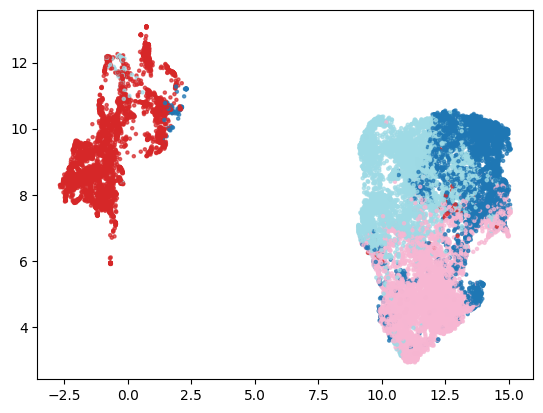

Running UMAP with n_neighbors=40


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



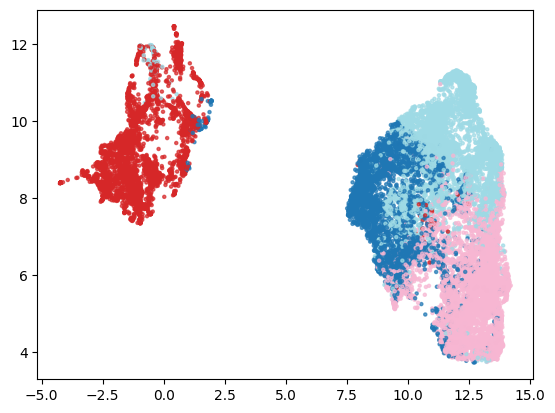

Running UMAP with n_neighbors=45


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



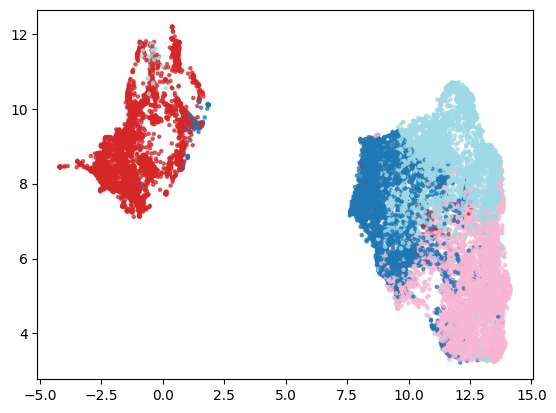

Running UMAP with n_neighbors=50


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



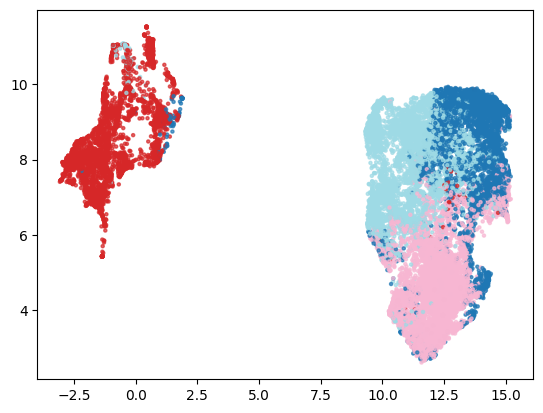

In [ ]:

# 3. Visualize in 2D UMAP
for n in ([10,15,20,25,30,35,40,45,50]):
    print(f"Running UMAP with n_neighbors={n}")
    X2 = umap.UMAP(n_components=2, min_dist = 0, n_neighbors = n,random_state=0).fit_transform(reduced_embedding)
    plt.scatter(X2[:,0], X2[:,1], c=kmean_labels, s=5, cmap='tab20', alpha=0.7)
    plt.show()

##seems like n=20 is a good choice 

In [49]:


# Compute 3D UMAP embedding
standard_embedding = umap.UMAP(
    random_state=42,
    metric='cosine',
    n_neighbors=50,
    n_components=3,
    min_dist=0.0
).fit_transform(reduced_embedding)



# Interactive 3D scatter plot with Plotly
fig = px.scatter_3d(
    x = standard_embedding[:,0],
    y= standard_embedding[:,1],
    z= standard_embedding[:,2],
    color=labels,
    title='3D UMAP Projection Colored by Clusters',
    color_discrete_sequence=px.colors.qualitative.Set1,
    opacity=0.8,
    width=1000,
    height=800
)

fig.update_layout(legend_title_text='Clusters')
fig.show()


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [42]:
standard_embedding[:,2]

array([2.007397 , 2.95824  , 2.4579556, ..., 3.7443347, 1.9103287,
       3.1029751], dtype=float32)